In [2]:
import numpy as np
from matplotlib import pyplot as plt
import csv
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation
import plotly.express as px
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


In [3]:
scz_path = 'clean_data/SCZ/schaefer1000'
controls_path = 'clean_data/controls/schaefer1000'

In [4]:
scz_subjects = np.loadtxt('COBRE_SCZ_subjects.txt', dtype = str)
control_subjects = np.loadtxt('COBRE_controls_subjects.txt', dtype = str)


In [5]:
panss = pd.read_csv('COBRE_assessmentData_17938.csv')
len(panss)
panss.replace({'Absent': 1, 'Minimal': 2, 'Mild': 3, 'MD':3, 'Moderate': 4, 'Moderate severe': 5, 'Severe': 6, 'Extreme': 7}, inplace=True)
panss = panss.dropna(subset = ["question_value"])
panss["question_value"] = panss["question_value"].astype(int)


2220

In [6]:
panss_total = pd.DataFrame(columns=['SubjectID', 'PANSS_Total'])

for subject in scz_subjects:
    df_subject = panss[panss['subjectid'] == subject]
    total_score = df_subject['question_value'].sum()
    panss_total = panss_total.append({'SubjectID': subject, 'PANSS_Total': total_score}, ignore_index=True)


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_4925/7172851.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  panss_total = panss_total.append({'SubjectID': subject, 'PANSS_Total': total_score}, ignore_index=True)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_4925/7172851.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  panss_total = panss_total.append({'SubjectID': subject, 'PANSS_Total': total_score}, ignore_index=True)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_4925/7172851.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  panss_total = panss_total.append({'SubjectID': subject, 'PANSS_Total': total_score}, ignore_index=True)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/

In [55]:
# save the total scores to a csv file
panss_total.to_csv('panss_total.csv', index=False)

# Pipeline
1. Normalize gradients relative to the neurotypical group gradient.
2. Multiple Linear Regression + LOO-CV
3. Support Vector Regression + LOO-CV


## 1. Gradient Normalization

In [ ]:
X_scz_grads = []

for subject in scz_subjects:
    subject_path = f'{scz_path}/sub-{subject}/func'
    grads = np.load(f'{subject_path}/aligned_10grads_{subject}_schaefer1000.npy')
    X_scz_grads.append(grads)

X_scz_grads = np.stack(X_scz_grads)

control_grads = []
for subject in control_subjects:
    subject_path = f'{controls_path}/sub-{subject}/func'
    grads = np.load(f'{subject_path}/aligned_10grads_{subject}_schaefer1000.npy')
    control_grads.append(grads)

control_grads = np.stack(control_grads)


In [ ]:
control_grads_reshaped = control_grads.reshape(control_grads.shape[0], -1)
X_scz_grads_reshaped = X_scz_grads.reshape(X_scz_grads.shape[0], -1)


In [ ]:
control_grads_reshaped.shape
X_scz_grads_reshaped.shape


In [ ]:
scaler = StandardScaler()
scaler.fit(control_grads_reshaped)
X_scz_grads_norm = scaler.transform(X_scz_grads_reshaped)

X_scz_grads_norm = X_scz_grads_norm.reshape(X_scz_grads.shape)


In [ ]:
control_group_grads = np.load(os.path.join(controls_path, 'aligned_control_group_10grads_schaefer1000.npy'))


## 2.1 Muptiple Linear Regression on Gradients + LOO-CV


In [ ]:
grad_combinations = np.arange(1, 11)

# Initialize a DataFrame to store the results
linreg_df = pd.DataFrame(columns=["Num_Gradients", "MSE_Train", "MSE_Test", "MAE_Train", "MAE_Test", "R2_Train", "R2_Test", "Obs_Left_Out", "Actual_Score", "Predicted_Score"])

# Loop over the gradient combinations
for n_grads in grad_combinations:
    # Select the specified gradients for both control and patient data
    X_scz_grads_norm_sub = X_scz_grads_norm[:, :, :n_grads]
    y_scz = panss_total['PANSS_Total'].values

    # Initialize the regression model and LOOCV object
    reg = LinearRegression()
    loocv = LeaveOneOut()

    # Initialize lists to store the MSE for each fold
    mse_train = []
    mse_test = []
    mae_train = []
    mae_test = []
    r2_train = []
    r2_test = []
    obs_left_out = []
    actual_scores = []
    predicted_scores = []

    # Loop over the LOOCV folds
    for train_idx, test_idx in loocv.split(X_scz_grads_norm_sub):

        # Split the data into training and testing sets
        X_train = X_scz_grads_norm_sub[train_idx]
        y_train = y_scz[train_idx]
        X_test = X_scz_grads_norm_sub[test_idx]
        y_test = y_scz[test_idx]

        # Fit the regression model to the training data
        reg.fit(X_train.reshape(len(train_idx), -1), y_train)

        # Predict the PNASS score for the training and testing data
        y_train_pred = reg.predict(X_train.reshape(len(train_idx), -1))
        y_test_pred = reg.predict(X_test.reshape(1, -1))

        # Calculate the MSE, MAE, and R^2 for the training and testing data
        mse_train.append(mean_squared_error(y_train, y_train_pred))
        mse_test.append(mean_squared_error(y_test, y_test_pred))
        mae_train.append(mean_absolute_error(y_train, y_train_pred))
        mae_test.append(mean_absolute_error(y_test, y_test_pred))
        r2_train.append(r2_score(y_train, y_train_pred))
        r2_test.append(r2_score(y_test, y_test_pred))
        
        # Append the index of the observation left out and the actual and predicted scores
        obs_left_out.append(test_idx[0])
        actual_scores.append(y_test[0])
        predicted_scores.append(y_test_pred[0])

    # Compute the mean MSE, MAE, and R^2 across all folds for both training and testing data
    mean_mse_train = np.mean(mse_train)
    mean_mse_test = np.mean(mse_test)
    mean_mae_train = np.mean(mae_train)
    mean_mae_test = np.mean(mae_test)
    mean_r2_train = np.mean(r2_train)
    mean_r2_test = np.mean(r2_test)

    filename = 'linreg_loocv_grads_panss_perf.csv'
    # Add the results to the DataFrame
    with open(filename, mode='a') as results_file:
        # Create a CSV writer object
        results_writer = csv.writer(results_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        
        # Write the header row if the file is empty
        if results_file.tell() == 0:
            results_writer.writerow(["Num_Gradients", "MSE_Train", "MSE_Test", "MAE_Train", "MAE_Test", "R2_Train", "R2_Test", "Obs_Left_Out", "Actual_Score", "Predicted_Score"])

        # Write the results for the current train and test session
        for i in range(len(mse_train)):
            results_writer.writerow([n_grads, mse_train[i], mse_test[i], mae_train[i], mae_test[i], r2_train[i], r2_test[i], obs_left_out[i], actual_scores[i], predicted_scores[i]])

In [ ]:
lingreg_loocv_grads_panss_results = pd.read_csv('linreg_loocv_grads_panss_perf.csv')

In [ ]:
lingreg_loocv_grads_panss_results["Rel_Error"] = lingreg_loocv_grads_panss_results["MAE_Test"]/lingreg_loocv_grads_panss_results["Actual_Score"]


In [ ]:
# Compute the mean and standard error of the mean for each number of gradients
mean_test = lingreg_loocv_grads_panss_results.groupby("Num_Gradients")["Rel_Error"].mean()
sem_test = lingreg_loocv_grads_panss_results.groupby("Num_Gradients")["Rel_Error"].sem()

# Plot the means and standard errors
fig, ax = plt.subplots()

ax.plot(mean_test.index, mean_test, label="Relative Error")
ax.fill_between(mean_test.index, mean_test - sem_test, mean_test + sem_test, alpha=0.2)
ax.legend()
ax.set_xlabel("Number of Gradients")
ax.set_ylabel("Mean Relative Error")
plt.show()

## 2.2 Muptiple Linear Regression on Dispersion + LOO-CV

In [6]:
n_neighbours_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]

In [7]:
n_grads_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [57]:
for n_grads in n_grads_list:
    for n_neighbours in n_neighbours_list:
        for subject in scz_subjects:
            gradients = np.load(f'{scz_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')[:, :n_grads]
            hcp_ngbrs = NearestNeighbors(n_neighbors=n_neighbours, algorithm='brute').fit(gradients)
            distances, indices = hcp_ngbrs.kneighbors(gradients)
            subj_disp = distances.mean(axis = 1)
            np.save(f'{scz_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy', subj_disp)

        for subject in control_subjects:
            gradients = np.load(f'{controls_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')[:, :n_grads]
            hcp_ngbrs = NearestNeighbors(n_neighbors=n_neighbours, algorithm='brute').fit(gradients)
            distances, indices = hcp_ngbrs.kneighbors(gradients)
            subj_disp = distances.mean(axis = 1)
            np.save(f'{controls_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy', subj_disp)

KeyboardInterrupt: 

In [56]:
control_subjects

array(['A00014898', 'A00024955', 'A00024663', 'A00024932', 'A00024820',
       'A00014839', 'A00025969', 'A00024446', 'A00024301', 'A00024372',
       'A00024535', 'A00024160', 'A00023866', 'A00023848', 'A00023800',
       'A00018716', 'A00013140', 'A00023330', 'A00023143', 'A00022915',
       'A00024546', 'A00023120', 'A00023095', 'A00022835', 'A00022773',
       'A00022687', 'A00022619', 'A00022837', 'A00022729', 'A00022810',
       'A00022727', 'A00022509', 'A00022653', 'A00022490', 'A00022400',
       'A00021058', 'A00026945', 'A00021081', 'A00020968', 'A00021072',
       'A00021085', 'A00020895', 'A00020805', 'A00020984', 'A00023337',
       'A00026907', 'A00004087', 'A00014522', 'A00002198', 'A00013363',
       'A00017294', 'A00013816', 'A00011265', 'A00003150', 'A00011725',
       'A00019888', 'A00012995', 'A00018553', 'A00007409', 'A00010150',
       'A00015826', 'A00022592', 'A00000300', 'A00014120', 'A00010684',
       'A00014225', 'A00027787', 'A00023131', 'A00028052', 'A000

In [ ]:
disp_dict = {}

for n_neighbours in n_neighbours_list:
    disp_list = []
    for subject in scz_subjects:
        disp = np.load(f'{scz_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy')
        disp_list.append(disp)
    for subject in control_subjects:
        disp = np.load(f'{controls_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy')
        disp_list.append(disp)

    disp_list = np.stack(disp_list)
    disp_dict[n_neighbours] = disp_list

## Normalize Dispersion Relative to Controls

In [ ]:
for n_neighbours in n_neighbours_list:
    scaler = StandardScaler()
    scaler.fit(disp_dict[n_neighbours][len(scz_subjects):])
    X_scz_disp_norm = scaler.transform(disp_dict[n_neighbours][:len(scz_subjects)])
    disp_dict[n_neighbours][:len(scz_subjects)] = X_scz_disp_norm

In [25]:
disp_array = []

for subject in scz_subjects:
    disp = np.load(f'{scz_path}/sub-{subject}/func/disp_{10}_{120}n_{subject}_schaefer1000.npy')
    disp_array.append(disp)

for subject in control_subjects:
    disp = np.load(f'{controls_path}/sub-{subject}/func/disp_{10}_{120}n_{subject}_schaefer1000.npy')
    disp_array.append(disp)
disp_array = np.stack(disp_array)
print(disp_array.shape)

(164, 1000)


In [26]:
linreg_df = pd.DataFrame(columns=["N_grads", "N_Neighbors", "MSE_Train", "MSE_Test", "MAE_Train", "MAE_Test", "R2_Train", "R2_Test", "Obs_Left_Out", "Actual_Score", "Predicted_Score"])

for n_grads in n_grads_list:
    for n_neighbours in n_neighbours_list:
        disp_array = []
        for subject in scz_subjects:
            disp = np.load(f'{scz_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy')
            disp_array.append(disp)
        for subject in control_subjects:
            disp = np.load(f'{controls_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy')
            disp_array.append(disp)

        disp_array = np.stack(disp_array)

        print(disp_array.shape)

        # Normalize scz disp relative to controls
        scaler = StandardScaler()
        scaler.fit(disp_array[len(scz_subjects):])
        X_scz_disp_norm = scaler.transform(disp_array[:len(scz_subjects)])
        disp_array[:len(scz_subjects)] = X_scz_disp_norm

        # Select the subset of subjects with the desired n_neighbours
        X_scz_disp_norm_sub = disp_array[:len(scz_subjects)]
        y_scz = panss_total['PANSS_Total'].values

        # Initialize the regression model and LOOCV object
        reg = LinearRegression()
        loocv = LeaveOneOut()

        # Initialize lists to store the MSE for each fold
        mse_train = []
        mse_test = []
        mae_train = []
        mae_test = []
        r2_train = []
        r2_test = []
        obs_left_out = []
        actual_scores = []
        predicted_scores = []

        # Loop over the LOOCV folds
        print("Fitting model...")
        for train_idx, test_idx in loocv.split(X_scz_disp_norm_sub):

            # Split the data into training and testing sets
            X_train = X_scz_disp_norm_sub[train_idx]
            y_train = y_scz[train_idx]
            X_test = X_scz_disp_norm_sub[test_idx]
            y_test = y_scz[test_idx]

            # Fit the regression model to the training data
            reg.fit(X_train.reshape(len(train_idx), -1), y_train)

            # Predict the PNASS score for the training and testing data
            y_train_pred = reg.predict(X_train.reshape(len(train_idx), -1))
            y_test_pred = reg.predict(X_test.reshape(1, -1))

            # Calculate the MSE, MAE, and R^2 for the training and testing data
            mse_train.append(mean_squared_error(y_train, y_train_pred))
            mse_test.append(mean_squared_error(y_test, y_test_pred))
            mae_train.append(mean_absolute_error(y_train, y_train_pred))
            mae_test.append(mean_absolute_error(y_test, y_test_pred))
            r2_train.append(r2_score(y_train, y_train_pred))
            r2_test.append(r2_score(y_test, y_test_pred))
            
            # Append the index of the observation left out and the actual and predicted scores
            obs_left_out.append(test_idx[0])
            actual_scores.append(y_test[0])
            predicted_scores.append(y_test_pred[0])

        # Compute the mean MSE, MAE, and R^2 across all folds for both training and testing data
        mean_mse_train = np.mean(mse_train)
        mean_mse_test = np.mean(mse_test)
        mean_mae_train = np.mean(mae_train)
        mean_mae_test = np.mean(mae_test)
        mean_r2_train = np.mean(r2_train)
        mean_r2_test = np.mean(r2_test)

        filename = 'linreg_loocv_disp_panss_perf.csv'
        # Add the results to the DataFrame
        with open(filename, mode='a') as results_file:
            # Create a CSV writer object
            results_writer = csv.writer(results_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            
            # Write the header row if the file is empty
            if results_file.tell() == 0:
                results_writer.writerow(["N_grads", "N_Neighbors", "MSE_Train", "MSE_Test", "MAE_Train", "MAE_Test", "R2_Train", "R2_Test", "Obs_Left_Out", "Actual_Score", "Predicted_Score"])

            # Write the results for the current train and test session
            for i in range(len(mse_train)):
                results_writer.writerow([n_grads, n_neighbours, mse_train[i], mse_test[i], mae_train[i], mae_test[i], r2_train[i], r2_test[i], obs_left_out[i], actual_scores[i], predicted_scores[i]])




(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...
(164, 1000)


StandardScaler()

Fitting model...


KeyboardInterrupt: 

In [7]:
lingreg_loocv_disp_panss_results = pd.read_csv('linreg_loocv_disp_panss_perf.csv')


In [10]:
lingreg_loocv_disp_panss_results["Rel_Error"] = lingreg_loocv_disp_panss_results["MAE_Test"]/lingreg_loocv_disp_panss_results["Actual_Score"]


In [16]:
lingreg_loocv_disp_panss_results[lingreg_loocv_disp_panss_results["N_grads"] == 1]

,N_grads,N_Neighbors,MSE_Train,MSE_Test,MAE_Train,MAE_Test,R2_Train,R2_Test,Obs_Left_Out,Actual_Score,Predicted_Score,Rel_Error
0,1,5,1.222208e-27,4.080847,2.713879e-14,2.020111,1.0,NaN,0,57,54.979889,0.035441
1,1,5,1.215898e-27,533.411854,2.664535e-14,23.095711,1.0,NaN,1,47,70.095711,0.491398
2,1,5,1.415742e-27,113.823045,2.930989e-14,10.668788,1.0,NaN,2,47,57.668788,0.226995
3,1,5,1.821743e-27,346.418474,3.394815e-14,18.612320,1.0,NaN,3,41,59.612320,0.453959
4,1,5,1.432571e-27,367.842464,2.891514e-14,19.179220,1.0,NaN,4,39,58.179220,0.491775
...,...,...,...,...,...,...,...,...,...,...,...,...
1747,1,120,1.706744e-27,575.991767,3.236917e-14,23.999828,1.0,NaN,68,36,59.999828,0.666662
1748,1,120,1.679397e-27,559.174128,3.187574e-14,23.646863,1.0,NaN,69,40,63.646863,0.591172
1749,1,120,1.041296e-27,464.645603,2.477031e-14,21.555640,1.0,NaN,70,83,61.444360,0.259707
1750,1,120,1.823145e-27,456.634590,3.177705e-14,21.369010,1.0,NaN,71,70,48.630990,0.305272


Text(0.5, 0, 'N_Neighbors')

Text(0, 0.5, 'Mean Rel_Error')

[Text(5, 0, '5'),
 Text(10, 0, '10'),
 Text(15, 0, '15'),
 Text(20, 0, '20'),
 Text(25, 0, '25'),
 Text(30, 0, '30'),
 Text(35, 0, '35'),
 Text(40, 0, '40'),
 Text(45, 0, '45'),
 Text(50, 0, '50'),
 Text(55, 0, '55'),
 Text(60, 0, '60'),
 Text(65, 0, '65'),
 Text(70, 0, '70'),
 Text(75, 0, '75'),
 Text(80, 0, '80'),
 Text(85, 0, '85'),
 Text(90, 0, '90'),
 Text(95, 0, '95'),
 Text(100, 0, '100'),
 Text(105, 0, '105'),
 Text(110, 0, '110'),
 Text(115, 0, '115'),
 Text(120, 0, '120')]

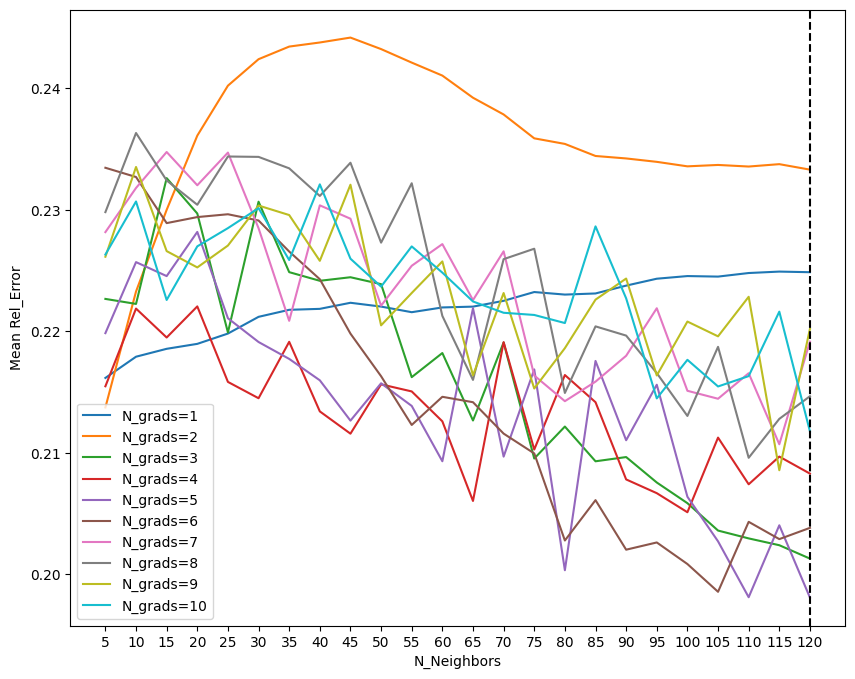

In [58]:
# Get the mean and SEM of Rel_Error for each combination of N_grads and N_Neighbors:
grouped = lingreg_loocv_disp_panss_results.groupby(['N_grads', 'N_Neighbors'])['Rel_Error'].agg(['mean']).reset_index()

# Set up the plot:
fig, ax = plt.subplots(figsize=(10,8))

# Loop over each unique N_grads value:
for n_grads_val in grouped['N_grads'].unique():
    # Filter the data to only include rows with this N_grads value:
    subset = grouped[grouped['N_grads'] == n_grads_val]
    
    # Plot a line for this N_grads value:
    ax.plot(subset['N_Neighbors'], subset['mean'], label=f'N_grads={n_grads_val}')

    
# Add labels and legend:
ax.set_xlabel('N_Neighbors')
ax.set_ylabel('Mean Rel_Error')
ax.legend()

xticks = grouped['N_Neighbors'].unique()
ax.set_xticks(xticks)

xticklabels = [str(x) for x in xticks]
ax.set_xticklabels(xticklabels)

min_mean_error = grouped['mean'].min()
# Add vertical line at the value of N_Neighbors corresponding to the minimum mean Rel_Error:
min_error_neighbors = grouped.loc[grouped['mean'] == min_mean_error, 'N_Neighbors'].iloc[0]
ax.axvline(min_error_neighbors, color='k', linestyle='--')

# Show the plot:
plt.show()


In [53]:
n_neighbours_list = np.concatenate([np.arange(5, 505, 5)] * 10)
n_grads_list = np.concatenate([np.array([i] * 100) for i in np.arange(1, 11)])
args_list = np.stack([n_grads_list, n_neighbours_list]).T

np.savetxt('args_panss_linreg.txt', args_list, fmt='%d')


In [54]:
scz_subjects

array(['A00014804', 'A00014830', 'A00024959', 'A00024568', 'A00024228',
       'A00024198', 'A00024953', 'A00016197', 'A00023750', 'A00023158',
       'A00000456', 'A00023243', 'A00022500', 'A00020787', 'A00023590',
       'A00024684', 'A00020414', 'A00000838', 'A00020602', 'A00001452',
       'A00019349', 'A00019293', 'A00018979', 'A00001181', 'A00018434',
       'A00018317', 'A00018129', 'A00016720', 'A00016723', 'A00015518',
       'A00014607', 'A00012767', 'A00000541', 'A00013216', 'A00014590',
       'A00002480', 'A00017147', 'A00001251', 'A00015648', 'A00015201',
       'A00028404', 'A00027537', 'A00000909', 'A00006754', 'A00018403',
       'A00000368', 'A00001243', 'A00021598', 'A00009280', 'A00023246',
       'A00027391', 'A00021591', 'A00014719', 'A00027410', 'A00028408',
       'A00004507', 'A00028405', 'A00028303', 'A00028805', 'A00028806',
       'A00029486', 'A00031186', 'A00031597', 'A00034273', 'A00035003',
       'A00035485', 'A00037034', 'A00037224', 'A00037619', 'A000